In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from gensim.models.tfidfmodel import TfidfModel
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
#Read in dataframe from Spotify Data Extraction section containing musical attributes
spotify_df = pd.read_csv('spotify_genre_df_cleaned.csv')

We will now tackle applying a series of machine learning algorithms to build a genre predictor using both the lyrics and the musical attributes, and potentially thereafter an ensemble model combining the two. Since the musical attributes are largely numerical data while the lyrics are of course text data, we would need to apply different models that can be fit, transform, and predict the data types. For our musical attributes, we will attempt two popular classifers for multivariate data and nondichotomous output variables with a Random Forest model as well as a Gradient Booster in XGBoost. For lyrical prediction, we will apply a Multinomial Naive Bayes model as a predictor and first fit and transform the data into a tokenized dictionary using both the Count Vectorizer and TFIDF, similar to the topic analysis in the EDA section. We will begin by creating a list of genres to loop through as well as all of our columns so we can select the features and target variables and create matrices of them.

In [9]:
genres = ['Rock', 'Country', 'Hip-Hop', 'Pop', 'EDM']
spotify_df.columns

Index(['track_name', 'artist', 'album', 'track_id', 'genre', 'danceability',
       'energy', 'full_key', 'key', 'mode', 'loudness', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_minutes',
       'duration_ms', 'time_signature', 'lyrics', 'lyrics_tokenized',
       'word_count', 'lyrics_cleaned', 'named_entities', 'word_count_cleaned',
       'word_count_unique', 'word_count_cleaned_unique', 'entity_count_unique',
       'count_artist', 'count_track', 'count_album', 'lyrics_cleaned_str',
       'full_key_num', 'mode_num', 'time_signature_num'],
      dtype='object')

Upon reviewing our columns, we see that we have a few features that are non-numerical values in key, mode, and time signature. These were converted to categorical variables in the data wrangling portion for interpretability as well as improved accuracy, but now unfortunately we will need to convert them back to numerical in order to combine them into our feature matrix with all of the other numerical features. We do this below by using the Sklearn tool LabelEncoder which converts categorical data into numerical.

In [4]:
label_encoder = LabelEncoder()
spotify_df['full_key_num'] = label_encoder.fit_transform(spotify_df['full_key'])
spotify_df['mode_num'] = label_encoder.fit_transform(spotify_df['mode'])
spotify_df['time_signature_num'] = label_encoder.fit_transform(spotify_df['time_signature'])

In [11]:
spotify_df[numerical_variables[11:]]

,full_key_num,mode_num,time_signature_num
0,6,0,2
1,1,1,2
2,0,0,2
3,8,0,2
4,6,0,2
...,...,...,...
9995,20,0,2
9996,14,0,2
9997,0,0,2
9998,20,0,2


After successfully converting all of our categorical data, we can now generate our feature matrices. After that is done, we can use Sklearn's train_test_split function to divide up our dataset into training and testing data. The testing data holdout can be varied depending on the size of your dataset and the variance, but based on having a fairly large data size we will use the common split of 80/20 train/test.

In [10]:
numerical_variables = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 
                       'valence', 'tempo', 'duration_minutes', 'word_count', 'word_count_unique', 
                       'full_key_num', 'mode_num', 'time_signature_num']

#Feature Selection - Create Feature and Target Matrix
features = spotify_df[numerical_variables]

target = spotify_df['genre']

#Reset train test split X and Y arrays with all 16 variables
X_train, X_test, y_train, y_test = train_test_split(features , target, test_size = 0.2, random_state = 0)

In [12]:
X_train

,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_minutes,word_count,word_count_unique,full_key_num,mode_num,time_signature_num
7389,0.797,0.375,-7.552,0.1460,0.000000,0.0767,0.171,139.999,3.200750,737.0,206.0,21,1,2
9275,0.600,0.496,-9.594,0.0247,0.001600,0.2560,0.516,100.511,3.872883,210.0,86.0,16,0,2
2995,0.393,0.805,-2.520,0.0471,0.000137,0.0746,0.325,74.931,3.286667,153.0,51.0,8,0,2
5316,0.570,0.664,-4.718,0.0322,0.000012,0.0719,0.487,162.084,3.558667,459.0,110.0,7,1,2
356,0.658,0.814,-4.631,0.0558,0.006760,0.2160,0.690,108.016,3.060033,266.0,64.0,6,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,0.513,0.488,-11.603,0.0321,0.006110,0.1200,0.947,169.601,4.282883,0.0,0.0,16,0,2
4859,0.634,0.153,-14.409,0.0622,0.000000,0.1340,0.318,77.770,3.692300,324.0,114.0,14,0,2
3264,0.474,0.749,-5.113,0.0363,0.000074,0.0642,0.100,121.969,5.904767,206.0,86.0,5,1,2
9845,0.573,0.847,-7.251,0.0341,0.000082,0.3830,0.795,153.971,3.251783,186.0,80.0,18,0,2


As you can see upon previewing the training feature dataset, we have a split of 80/20 with a dataframe containing 8000 of our 10000 tracks data. We will now instantiate our two classification models in the Random Forest and Gradient Boosting Tree. We will start with the Random Forest and first apply a grid search in order to find the optimal hyperparameters to instatiate our Random Forest Classifier with.

In [13]:
#Random Forest Classifier
param_grid = {'max_depth': range(5, 50, 5), 'n_estimators': range(1, 20)} 
rand_forest_grid = RandomForestClassifier(random_state=0)
rf_gridsearch = GridSearchCV(estimator=rand_forest_grid, param_grid=param_grid, cv=5)
rf_gridsearch.fit(X_train, y_train)


y_pred = rf_gridsearch.predict(X_test)

In [14]:
rf_gridsearch.best_score_, rf_gridsearch.best_estimator_, rf_gridsearch.score(X_test, y_test)

(0.723,
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=15, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=1,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 0.7155)

Running through the grid search and fitting it to our training data helped to determine that the optimal parameters on our grid, which included the hyperparameters 'max_depth' and 'n_estimators' is 15 and 18 respectively. We also discover that the best accuracy score yielded when running through the grid search is .7155, indicating a 71.55% success in classifying the genre of the 2000 songs in the test data correctly. We will now apply these hyperparameters to our random forest model and predict test data labels so we can genrate a classification report as well as a confusion matrix.

In [15]:
rand_forest = RandomForestClassifier(random_state=0, max_depth=15, n_estimators=18)
rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

         Country       0.67      0.70      0.68       412
Electronic/Dance       0.81      0.76      0.78       398
         Hip-Hop       0.85      0.88      0.87       398
             Pop       0.64      0.62      0.63       419
            Rock       0.62      0.62      0.62       373

     avg / total       0.72      0.72      0.72      2000



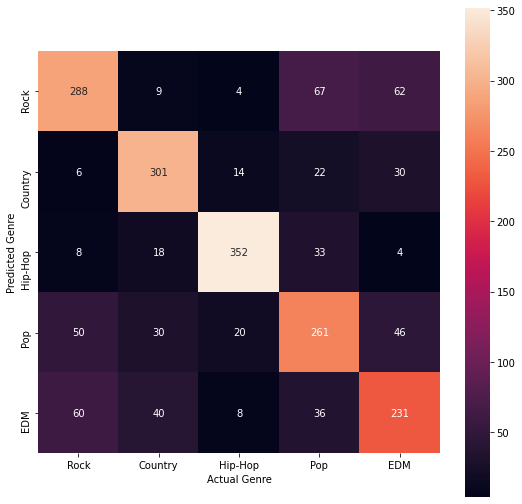

In [40]:
mat1 = confusion_matrix(y_test, y_pred)
sns.heatmap(mat1.T, square=True, annot=True, fmt='d', cbar=True, xticklabels=genres, yticklabels=genres)
plt.rcParams['figure.figsize'] = (9, 9)
plt.xlabel('Actual Genre')
plt.ylabel('Predicted Genre')
plt.show()

Based on the classification report, it appears that the Hip-Hop and EDM tracks had a greater success rate of being classified according to their existing labels through our random forest model. Likewise, the tracks within Rock, Pop, and Country had lower true positive rates closer to 60%. Thinking back to our exploratory data analysis that reviewed the distributions of features across genres, this result is understandable considering these 3 genres had a lot more similarities in their distribution values across most numerical features, whereas the Hip-Hop and EDM genres had some distinguishing features such as high instrumentallness amongst our EDM data and high speechiness and word counts amongst our Hip-Hop data.

Taking a look at the confusion matrix, we can gain a better idea as to what genres were classified more successfully than others and amongst the songs misclassified, what they were misclassified as. It appears the highest count of incorrectly classified tracks were songs that were actually Pop (as labeled by Spotify based on artist data) but predicted to be classified as Rock through the Random Forest model. Other notable misclassifications include Rock songs classified as Pop or EDM as well as EDM songs classified as Rock. It is curious that Rock and EDM tracks were misclassified as one another more often than others, but it is potentially possible due to the similar high levels of energy and loudness. 

While observing and attempting to understand the confusion matrix, the question arises as to what features in our dataset are having a high impact on the classification algorithm. Answering this question may help us in turn answer why certain genres were incorrectly classified as one another. Fortunately, the Random Forest classifier model has a built in method that yields the highest ranked features as well as a numerical measure of their importance. We can use this to create a simple bar plot of feature importance to provide us insights to answer some questions.

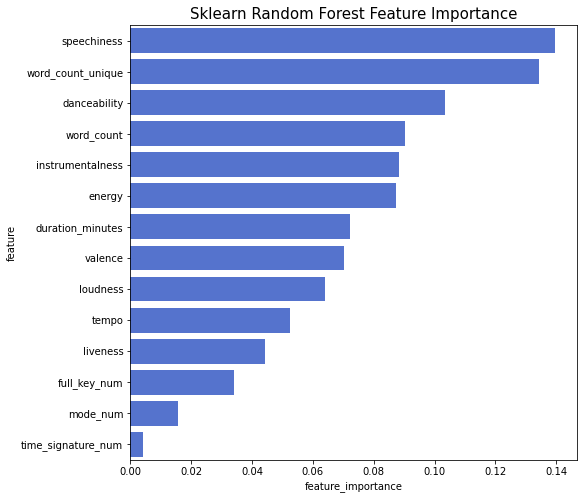

In [18]:
df_feature_importance = pd.DataFrame({'feature': X_train.columns,
                       'feature_importance': rand_forest.feature_importances_}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        
sns.barplot(x = 'feature_importance', y = 'feature', data = df_feature_importance, orient = 'h', color = 'royalblue').set_title('Sklearn Random Forest Feature Importance', fontsize = 15)
        
plt.show()

Plotting the feature importance helps us greatly in revealing the features that have the most significant impact in the genre prediction model. We can see that speechiness is the top ranked feature with word count just behind it, which asserts our hypothesis that Hip-Hop is the most accurately classified genre as a result of the majority of songs in our dataset having distinguishing features in higher values of speechiness and word count. Likewise, danceability and instrumentallness are both amongst the top 5 features, which supports the higher accuracy amongst EDM songs where those two features are distinguishably higher. We also notice that the categorical variables (key, mode, and time signature) that were translated into numerical as all at the bottom of the chart. This was predicted based on the overall randomness in the countplot distribution for these features we plotted in the EDA report.

Overall, the random forest model proved to be fairly strong and provided us with several interesting insights. We will move on to test out a gradient boosting model using XGBoost, a popular tool that has often regarded highly in performance for classification. We will similarly apply a gridsearch to tune our hyperparameters and then fit that model to our testing data to generate a classification report and confusion matrix.

In [19]:
%%capture
param_grid_xg = {'booster': ['gblinear', 'gbtree'], 'n_estimators': range(1, 20)} 
xg_grid = xgb.XGBClassifier()
xg_gridsearch = GridSearchCV(estimator= xg_grid, param_grid= param_grid_xg, cv=5)
xg_gridsearch.fit(X_train, y_train)

In [20]:
xg_gridsearch.best_score_, xg_gridsearch.best_estimator_

(0.65675, XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
        n_estimators=19, n_jobs=1, nthread=None, objective='multi:softprob',
        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=None, silent=None, subsample=1, verbosity=1))

In [21]:
xgb_grid = xgb.XGBClassifier(random_state=0, max_depth=3, n_estimators=19)
xgb_grid.fit(X_train, y_train)
y_pred2 = xgb_grid.predict(X_test)
print(print(classification_report(y_test, y_pred2)))

                  precision    recall  f1-score   support

         Country       0.58      0.69      0.63       412
Electronic/Dance       0.77      0.71      0.74       398
         Hip-Hop       0.76      0.83      0.79       398
             Pop       0.56      0.47      0.51       419
            Rock       0.58      0.55      0.56       373

     avg / total       0.65      0.65      0.65      2000

None


/Users/varunraja/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


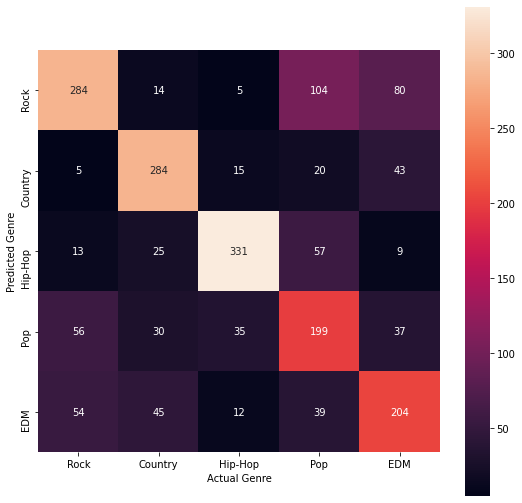

In [39]:
mat2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(mat2.T, square=True, annot=True, fmt='d', cbar=True, xticklabels=genres, yticklabels=genres)
plt.rcParams['figure.figsize'] = (9, 9)
plt.xlabel('Actual Genre')
plt.ylabel('Predicted Genre')
plt.show()

After running the models and generating our reports just like we did on the Random Forest, we see that the overall score of the model is slightly lower at around 65% correct classification on the test data. Moreover, the confusion matrix and classification report yield fairly similar misclassification results between the predicted and actual genres, with Pop, EDM, and Rock being among the most conflated. Given the general success of gradient boosting and XGBoost for classification modeling, it's possible we need to dive a bit further into the hyperparameter tuning and cross validation to potentially yield better results. We will leave this as an avenue to explore for next steps.

With the two models build around our numerical features, we will now proceed to apply our lyrical text data to two different vectorizers and use Multinomial Naive Bayes to classify the genres based solely on lyrical data. We will begin by splitting our data into a training and testing set once again, generating a piperline to transform data using the count vectorizer and then fitting it to a classifier.

In [26]:
#Reset train test split X and Y arrays with all 16 variables

lyrics = spotify_df.lyrics_cleaned

X_train, X_test, y_train, y_test = train_test_split(lyrics, target, test_size = 0.2, random_state = 0)

# define our model
genre_clf = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
genre_clf.fit(X_train, y_train)  

# score our model on testing data
y_pred3 = genre_clf.predict(X_test)
np.mean(y_pred3 == y_test)

0.5825

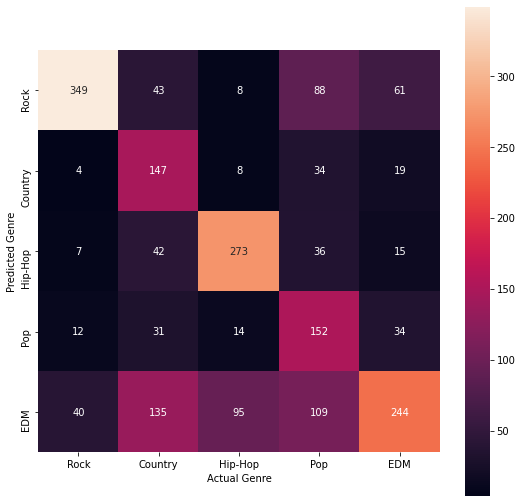

In [38]:
mat3 = confusion_matrix(y_test, y_pred3)
sns.heatmap(mat3.T, square=True, annot=True, fmt='d', cbar=True, xticklabels=genres, yticklabels=genres)
plt.rcParams['figure.figsize'] = (9, 9)
plt.xlabel('Actual Genre')
plt.ylabel('Predicted Genre')
plt.show()

Reviewing the results, we see a much lower accuracy score with about 58% of the test data being classified accurately. However, considering we are only using one input variable in lyrics rather than multiple numerical metrics, this is still a fairly strong model given those limitations. The confusion report once again helps us gain insight into which genres were incorrectly classified as which. Taking a quick glance at it, we notice some similar high numbers between Pop, EDM, and Rock. The true Rock tracks do surprisingly have the highest success rate with 349 of 412 being accurately classified. Amongst the highest genres misclassified were Country, Pop, and EDM against one another. Recalling the word clouds of the 5 genres, there did appear to be considerable overlap between those three genres, which helps explain these misclassifications.

Like we did when charting our top 10 word count across genres, we will now attempt to fit a Multinomial Naive Bayes model to our lyrics transformed using a TFIDF vectorizer to see if there is any improvement by reducing the weight of common words across the lyrics in each genre.

In [28]:
# define our model
genre_clf = Pipeline(
    [('vect', TfidfVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
genre_clf.fit(X_train, y_train)  

# score our model on testing data
y_pred4 = genre_clf.predict(X_test)
np.mean(y_pred4 == y_test)

0.5765

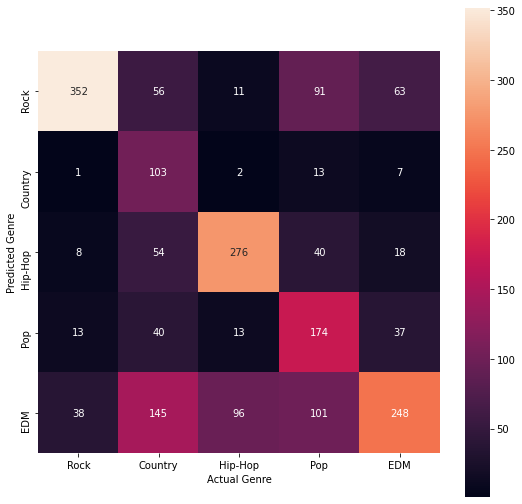

In [37]:
mat4 = confusion_matrix(y_test, y_pred4)
sns.heatmap(mat4.T, square=True, annot=True, fmt='d', cbar=True, xticklabels=genres, yticklabels=genres)
plt.rcParams['figure.figsize'] = (9, 9)
plt.xlabel('Actual Genre')
plt.ylabel('Predicted Genre')
plt.show()

The results of the TFIDF classification are largely similar to the Count Vectorizer with a slightly lower but nearly identical percentage of 57.65 correctly classified, with the confusion matrix reflecting nothing particularly new or insightful. This suggests that there isn't a strong benefit in weighting words that appear more frequently across lyrics less and boosting unique words.

After running these 4 models, we've generated a number of relatively accurate predictors using our acquired dataset. While both the lyric and numerical predictors served to be fairly adequate on their own, another avenue that could be explored is to create an ensemble model which combines the two by first predicting genre likelihood through lyrics and then using that to boost the predictability of the Random Forest or XGBoost models. This is something we will consider are a potential avenue for next steps in a future project.